# Baseline Modeling - Classification

---

Before diving into feature engineering, it’s crucial to establish baseline models to understand the inherent predictive power of the existing features and to identify any immediate challenges, such as class imbalances or model biases. Baseline modeling provides a reference point against which the effectiveness of future feature engineering and model tuning can be measured. By evaluating the performance of these initial models, I can identify key areas for improvement and ensure that the dataset is well-suited for more advanced modeling techniques. 

For this initial phase, I will use a RandomForestClassifier to assess the performance of a straightforward ensemble method, and a HistGradientBoostingClassifier (HGBC) to explore the potential of a more sophisticated gradient boosting approach.

---

# Import Packages and Load Data

In [2]:
import pandas as pd
from sklearn import set_config

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import (cross_val_predict, cross_val_score,
                                     StratifiedKFold, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

In [3]:
## Load datasets and add column to indicate hotel type/location

data = pd.read_parquet('../../data/raw/H2.parquet')
data['ReservationStatusDate'] = pd.to_datetime(data['ReservationStatusDate'], format='%Y-%m-%d')

# Review Target: `IsCanceled`

In [4]:
data['IsCanceled'].value_counts(normalize=True).round(2)

IsCanceled
0    0.58
1    0.42
Name: proportion, dtype: float64

# Modeling Pipeline

## Train/Test Split

In [5]:
## Train/Test Split
X = data.drop(columns = ['ReservationStatus', 'IsCanceled'])
y = data['IsCanceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y)

# Initial Model - Random Forest Classifier

---

I'm starting with a `RandomForestClassifier` model due to its robust and accurate performance history.

I expect this model to overfit without performing any hyperparameter tuning or handling of class imbalances. I will address both problems in the revised modeling.

---

In [7]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                #    min_frequency=10,
                                                #    max_categories = 25
                                                   ))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])  

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))])

model_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [8]:
print(f'Training Score: {model_pipeline.score(X_train, y_train):.2f}')
print(f'Testing Score: {model_pipeline.score(X_test, y_test):.2f}')

Training Score: 1.00
Testing Score: 0.89


              precision    recall  f1-score   support

           0       0.88      0.93      0.90     11557
           1       0.90      0.82      0.86      8276

    accuracy                           0.89     19833
   macro avg       0.89      0.88      0.88     19833
weighted avg       0.89      0.89      0.88     19833



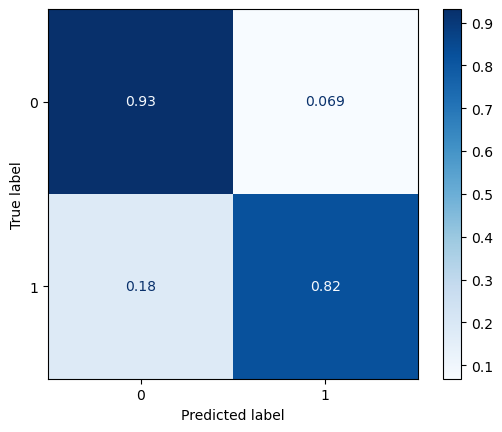

In [9]:
y_pred = model_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');

In [10]:
## Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=903)

## Fit the model and generate predictions
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf, n_jobs=-1, scoring='f1')

## Evaluate performance metrics
print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [0.86015416 0.864767   0.86355731 0.86048164 0.86005693]
Mean CV Score: 0.862
Standard Deviation of CV Scores: 0.002



              precision    recall  f1-score   support

           0       0.88      0.94      0.91     46228
           1       0.90      0.82      0.86     33102

    accuracy                           0.89     79330
   macro avg       0.89      0.88      0.88     79330
weighted avg       0.89      0.89      0.89     79330



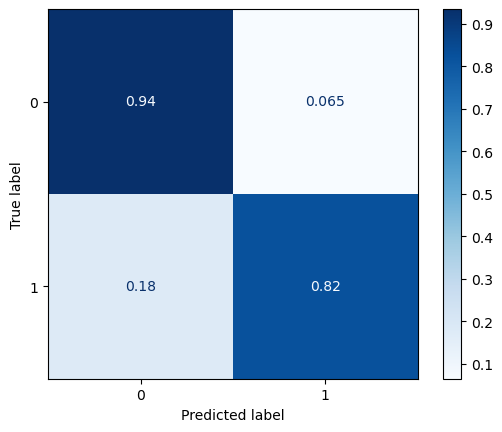

In [11]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

# print(classification_report(y_test, y_pred))
print(classification_report(y, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues', normalize='true');
ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

In [ ]:
# # Access the fitted model
# fitted_model = model_pipeline[-1]

# # Get the depths of the trees in the fitted model
# depths = [tree.get_depth() for tree in fitted_model.estimators_]

# # Plot the histogram of tree depths
# sns.histplot(depths);

# HistGradientBoostingClassifier

In [16]:
# Select categorical and numerical features
cat_feats = X_train.select_dtypes(include=['object']).columns
num_feats = X_train.select_dtypes(include=['number']).columns

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 50))])

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

# Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', HistGradientBoostingClassifier(class_weight = 'balanced',
                                                                              #  scoring = 'f1_weighted'
                                                                               ))])

best_model = model_pipeline.fit(X_train, y_train)

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(best_model, X, y, cv=skf, scoring='f1', n_jobs=-1, )

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [0.8429182  0.8455248  0.84108788 0.83896084 0.84267549]
Mean CV Score: 0.842
Standard Deviation of CV Scores: 0.002



              precision    recall  f1-score   support

           0       0.89      0.88      0.89     46228
           1       0.84      0.85      0.84     33102

    accuracy                           0.87     79330
   macro avg       0.86      0.87      0.86     79330
weighted avg       0.87      0.87      0.87     79330



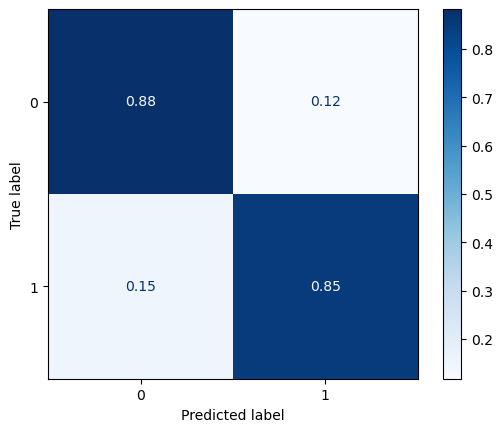

In [17]:
# Generate cross-validated predictions
y_pred_cv = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)

# Evaluate performance metrics
print(classification_report(y, y_pred_cv))
ConfusionMatrixDisplay.from_predictions(y, y_pred_cv, cmap='Blues', normalize='true');

# Summary and Next Steps

---

In the baseline modeling phase, I tested various classifiers to evaluate their initial performance on the dataset for the second hotel's dataset.

Both the **RandomForestClassifier** and the **HistGradientBoostingClassifier** show promising results, with F1 scores of about .80 on cross-validated data. Although this is a solid starting point, there is still room for improvement.

My next steps will involve performing feature engineering to further develop the dataset, addressing potential class imbalances, and enhancing the predictive performance of the models.

---